Setup: Install Packages & Import Libraries

Explanation:
This block first installs the necessary packages for creating interactive dashboards in Jupyter/Colab (dash and jupyter-dash).
Then, it imports all the Python libraries needed for:

Data handling: pandas, numpy

Visualization: matplotlib, seaborn, plotly

Time series forecasting: ARIMA, Holt-Winters, Prophet

Machine learning: TensorFlow, Keras

Dashboard creation: Dash, JupyterDash

In [3]:
!pip install dash
!pip install jupyter-dash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00


In [15]:
# ===============================
# Step 1: Import Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [16]:
# ===============================
# Step 2: Generate Sample Data
# ===============================

# For demo purposes, generating random daily sales data
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=365, freq='D')
sales = np.random.randint(50, 200, size=len(dates))
promotion = np.random.choice([0,1], size=len(dates))
holiday = np.random.choice([0,1], size=len(dates))

df = pd.DataFrame({
    'date': dates,
    'sales': sales,
    'promotion': promotion,
    'holiday': holiday
})

df.head()


,date,sales,promotion,holiday
0,2023-01-01,152,1,1
1,2023-01-02,142,0,0
2,2023-01-03,64,0,0
3,2023-01-04,156,1,0
4,2023-01-05,121,1,0


In [17]:
# ===============================
# Step 3: Data Preprocessing & Feature Engineering
# ===============================

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Lag features
df['lag_1'] = df['sales'].shift(1)
df['lag_7'] = df['sales'].shift(7)

# Rolling averages
df['rolling_7'] = df['sales'].rolling(7).mean()
df['rolling_30'] = df['sales'].rolling(30).mean()

# Drop NaNs
df = df.dropna()

# Weekly and monthly aggregations
weekly_sales = df.resample('W', on='date').sum().reset_index()
monthly_sales = df.resample('M', on='date').sum().reset_index()

df.head()


,date,sales,promotion,holiday,lag_1,lag_7,rolling_7,rolling_30
29,2023-01-30,104,0,0,157.0,71.0,109.857143,123.633333
30,2023-01-31,113,0,0,104.0,138.0,106.285714,122.333333
31,2023-02-01,180,1,1,113.0,98.0,118.000000,123.600000
32,2023-02-02,100,1,0,180.0,108.0,116.857143,124.800000
33,2023-02-03,184,0,1,100.0,64.0,134.000000,125.733333


Explore Data Patterns (EDA)

Explanation:
This block visualizes the sales data to understand trends and relationships:

Plot daily sales with a 7-day rolling average to see patterns over time

Show correlation between sales, promotion, and holiday to see how they affect demand

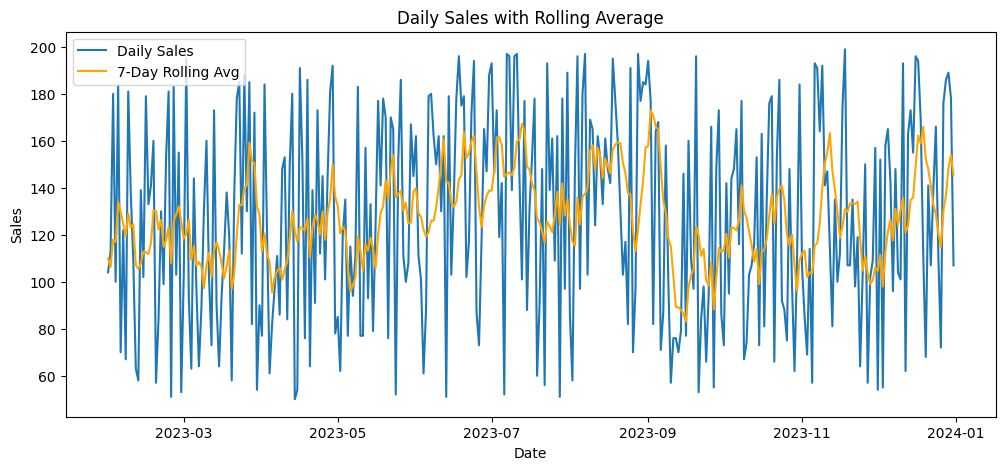

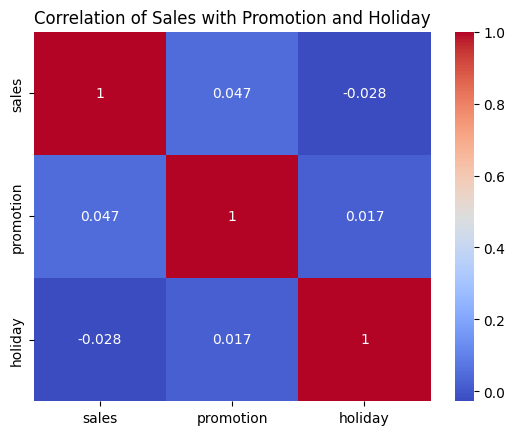

In [18]:
# ===============================
# Step 4: EDA
# ===============================

plt.figure(figsize=(12,5))
plt.plot(df['date'], df['sales'], label='Daily Sales')
plt.plot(df['date'], df['rolling_7'], label='7-Day Rolling Avg', color='orange')
plt.title("Daily Sales with Rolling Average")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

sns.heatmap(df[['sales','promotion','holiday']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Sales with Promotion and Holiday")
plt.show()


Time Series Forecasting

Explanation:
This section builds and evaluates multiple forecasting models:

ARIMA: Captures trend and autocorrelation for short-term prediction

Holt-Winters: Accounts for trend and seasonality

Prophet: Handles daily and weekly patterns with additional factors like promotion and holiday

LSTM: Uses deep learning to learn complex patterns in sales data

For each model:

Train on historical data

Forecast future sales

Compare predicted vs actual sales with visual plots

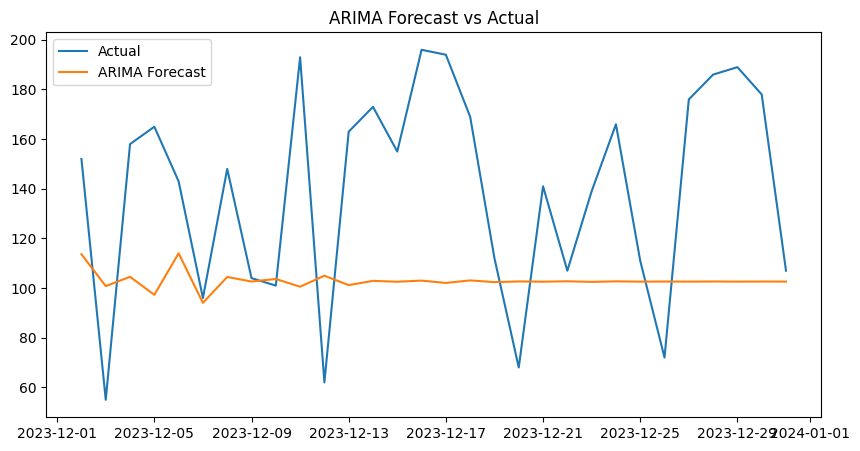

ARIMA RMSE: 55.29


In [19]:
# ===============================
# Step 5: ARIMA Forecasting
# ===============================

train = df.iloc[:-30]
test = df.iloc[-30:]

model_arima = ARIMA(train['sales'], order=(5,1,0))
arima_result = model_arima.fit()
forecast_arima = arima_result.forecast(steps=30)

plt.figure(figsize=(10,5))
plt.plot(test['date'], test['sales'], label='Actual')
plt.plot(test['date'], forecast_arima, label='ARIMA Forecast')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

rmse_arima = np.sqrt(mean_squared_error(test['sales'], forecast_arima))
print(f"ARIMA RMSE: {rmse_arima:.2f}")


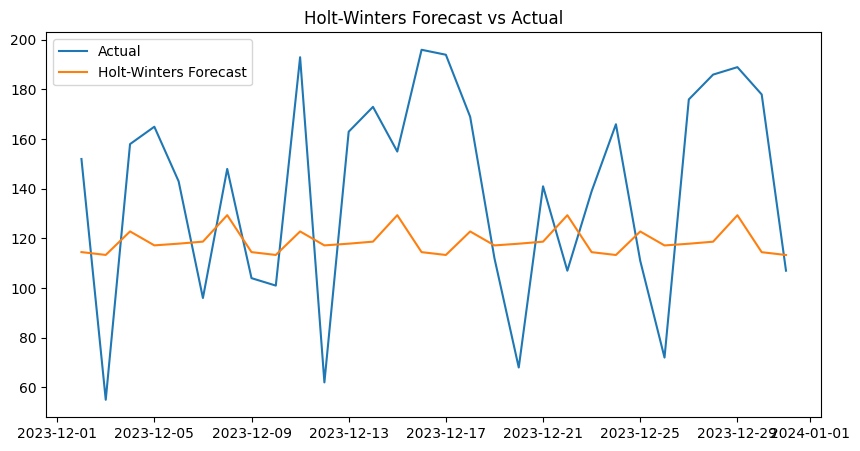

Holt-Winters RMSE: 46.04


In [20]:
# ===============================
# Step 6: Holt-Winters Forecast
# ===============================

model_hw = ExponentialSmoothing(train['sales'], trend='add', seasonal='add', seasonal_periods=365)
hw_result = model_hw.fit()

forecast_hw = hw_result.forecast(30)

plt.figure(figsize=(10,5))
plt.plot(test['date'], test['sales'], label='Actual')
plt.plot(test['date'], forecast_hw, label='Holt-Winters Forecast')
plt.title("Holt-Winters Forecast vs Actual")
plt.legend()
plt.show()

rmse_hw = np.sqrt(mean_squared_error(test['sales'], forecast_hw))
print(f"Holt-Winters RMSE: {rmse_hw:.2f}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwvgeyl1r/m50rpifw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwvgeyl1r/yl_eyw18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60692', 'data', 'file=/tmp/tmpwvgeyl1r/m50rpifw.json', 'init=/tmp/tmpwvgeyl1r/yl_eyw18.json', 'output', 'file=/tmp/tmpwvgeyl1r/prophet_model9f5bb34g/prophet_model-20250907091858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:18:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:18:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


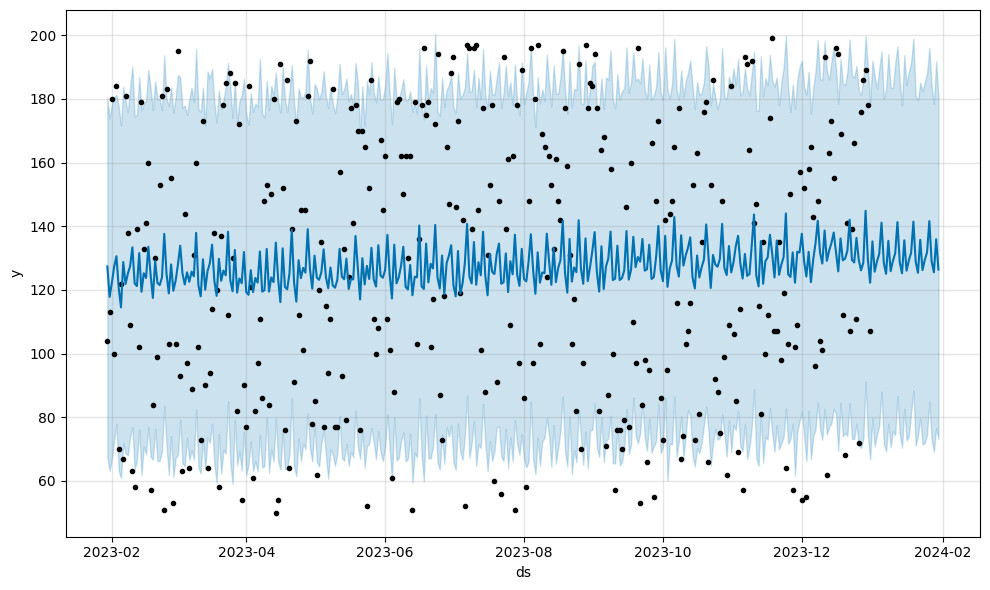

In [26]:
# ===============================
# Step 7: Prophet Forecasting (Corrected)
# ===============================

# Include all regressors in the dataframe
prophet_df = df[['date','sales','promotion','holiday']].rename(columns={'date':'ds','sales':'y'})

# Initialize Prophet with daily and weekly seasonality
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)

# Add regressors
model_prophet.add_regressor('promotion')
model_prophet.add_regressor('holiday')

# Fit the model
model_prophet.fit(prophet_df)

# Create future dataframe for next 30 days
future = model_prophet.make_future_dataframe(periods=30)

# Correctly add regressors: historical + future
future['promotion'] = pd.concat([df['promotion'], pd.Series([0]*30)], ignore_index=True)
future['holiday'] = pd.concat([df['holiday'], pd.Series([0]*30)], ignore_index=True)

# Predict
forecast_prophet = model_prophet.predict(future)

# Plot the forecast
model_prophet.plot(forecast_prophet)
plt.show()


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2339
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1033
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0922
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0895
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0867
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0864
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0955
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0929
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0890
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0902
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0898
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1045
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0845
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0925
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0911
Epoch 16/50
17/17 ━

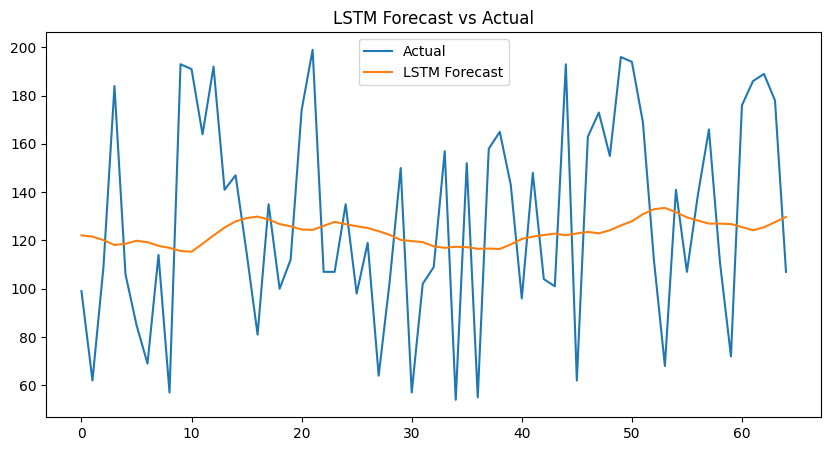

In [23]:
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(df['sales'].values.reshape(-1,1))

def create_sequences(data, seq_length=14):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_sales)
split = int(0.8*len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model_lstm = Sequential([
    LSTM(50, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

preds = model_lstm.predict(X_test)
preds = scaler.inverse_transform(preds)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label='Actual')
plt.plot(preds, label='LSTM Forecast')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.show()


In [24]:
forecast_mean = np.mean(preds)
forecast_std = np.std(preds)
service_level_z = 1.65  # 95% confidence
safety_stock = service_level_z * forecast_std
optimal_inventory = forecast_mean + safety_stock

print(f"Recommended Inventory Level: {optimal_inventory:.2f}")


Recommended Inventory Level: 131.05


Interactive Forecast Dashboard

Explanation:
This section creates an interactive dashboard to visualize forecasts and plan inventory:

Install & import dashboard tools: Dash, JupyterDash, pyngrok for hosting in Colab

Connect to ngrok: Generate a public URL to access the dashboard

Prepare forecast data: Combine predictions from ARIMA, Holt-Winters, LSTM, and Prophet

Build dashboard layout:

Dropdown to select forecast model

Slider to choose forecast horizon (days)

Checklist to simulate promotion or holiday effects

Graph showing actual vs forecasted sales

Display recommended inventory level based on forecast and safety stock

Callback function: Updates graph and inventory calculation dynamically based on user inputs

Run dashboard: Launches the interactive app in a browser or Colab

In [55]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [30]:
# Install latest stable Dash and pyngrok
!pip install dash pyngrok jupyter-dash --quiet


In [41]:
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
from pyngrok import ngrok
import plotly.graph_objects as go


In [48]:
from pyngrok import ngrok

# List all existing tunnels
print(ngrok.get_tunnels())

# Kill all existing tunnels
ngrok.kill()


[<NgrokTunnel: "https://29094fa504a0.ngrok-free.app" -> "http://localhost:8050">, <NgrokTunnel: "https://e625bda1d407.ngrok-free.app" -> "http://localhost:8050">, <NgrokTunnel: "https://63543825915a.ngrok-free.app" -> "http://localhost:8050">]


In [49]:
!ngrok authtoken 32MjDQ7bDygMCbkukpytGpwjCWU_2fuQ1H8aN8xLLrCZ5HMQY
from pyngrok import ngrok

public_url = ngrok.connect(8050)
print(public_url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
NgrokTunnel: "https://7d624cf135bf.ngrok-free.app" -> "http://localhost:8050"


In [50]:
forecast_dict = {
    'ARIMA': forecast_arima.values,
    'Holt-Winters': forecast_hw.values,
    'LSTM': preds.flatten(),
    'Prophet': forecast_prophet['yhat'].iloc[-30:].values
}


In [51]:
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Retail Sales Forecast Dashboard", style={'textAlign':'center'}),

    html.Label("Select Forecast Model:"),
    dcc.Dropdown(
        id='model_dropdown',
        options=[{'label': k, 'value': k} for k in forecast_dict.keys()],
        value='LSTM',
        clearable=False
    ),

    html.Label("Forecast Horizon (days):"),
    dcc.Slider(
        id='horizon_slider',
        min=7, max=60, step=1, value=30,
        marks={i:str(i) for i in range(7,61,7)}
    ),

    dcc.Checklist(
        id='scenario_check',
        options=[
            {'label':'Apply Promotion Boost', 'value':'promotion'},
            {'label':'Apply Holiday Effect', 'value':'holiday'}
        ],
        value=[]
    ),

    dcc.Graph(id='forecast_graph'),
    html.H3(id='inventory_output', style={'padding':10})
])


In [52]:
@app.callback(
    [Output('forecast_graph','figure'),
     Output('inventory_output','children')],
    [Input('model_dropdown','value'),
     Input('horizon_slider','value'),
     Input('scenario_check','value')]
)
def update_dashboard(model_name, horizon, scenario):
    forecast_values = forecast_dict[model_name][:horizon].copy()

    # Apply promotion/holiday boosts
    if 'promotion' in scenario:
        forecast_values += 15
    if 'holiday' in scenario:
        forecast_values += 10

    # Inventory calculation
    mean_forecast = np.mean(forecast_values)
    std_forecast = np.std(forecast_values)
    safety_stock = 1.65 * std_forecast
    optimal_inventory = mean_forecast + safety_stock

    # Plot figure
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['date'].iloc[-horizon:], y=forecast_values, mode='lines', name=f'{model_name} Forecast'))
    fig.add_trace(go.Scatter(x=df['date'], y=df['sales'], mode='lines', name='Actual Sales'))
    fig.update_layout(title=f"{model_name} Forecast vs Actual (Next {horizon} Days)",
                      xaxis_title="Date", yaxis_title="Sales")

    return fig, f"Recommended Inventory Level: {optimal_inventory:.2f}"


In [54]:
app.run(port=8050)


<IPython.core.display.Javascript object>